In [9]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from keras.models import Model, Input
from keras.preprocessing import image
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
import glob
import warnings
warnings.filterwarnings('ignore')

**6.1 Data Preparation**

**_5.1 Data Preparation**

In [10]:
# List all filename in face image path
filenames = glob.glob('face_mini/**/*.jpg', recursive=True)

# Load image files and Resize (h,w,ch) -> h = w < 100 , ch = 3 (R,G,B)
# Convert the image to an array
# Normalized color image
all_images = []
for i in filenames:
    img = image.load_img(i, target_size=(100,100,3), interpolation="nearest")
    img = image.img_to_array(img)
    img = img / 255
    all_images.append(img)

# Convert to numpy array
all_images = np.array(all_images)
print(all_images.shape)

# split data into train and validation data
train_x, test_x = train_test_split(all_images, random_state=32, test_size=0.3)
train_x, val_x = train_test_split(train_x, random_state=32, test_size=0.3)

(3203, 100, 100, 3)


**_5.2 Add noise**

In [11]:
# Add Noise
#   Scala between 0-1
noise_factor = 0.2 # 0-1

# กำหนด noise parameter
Nmean = 0
Nstd = 1

# Use np.random.normal to generate normal distribution (gaussian) noise
x_train_noisy = train_x + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=train_x.shape))

x_val_noisy = val_x + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=val_x.shape))

x_test_noisy = test_x + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=test_x.shape))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


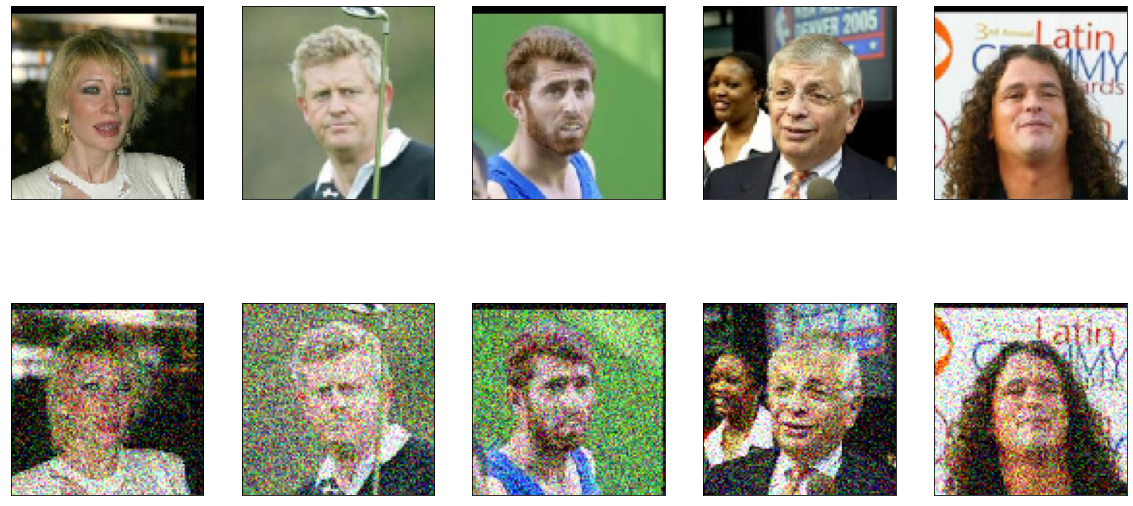

In [12]:
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow(val_x[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(x_val_noisy[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.savefig('act5_2.png', facecolor="white", transparent=True)
plt.show()

**6.2 create_model** (Autoencoder)

In [13]:
#Create_model function
def create_model(optimizer='adam'):
    Input_img = Input(shape=(80, 80, 3))

    x1 = Conv2D(256,(3,3), activation='relu',padding='same')(Input_img)
    x2 = Conv2D(128,(3,3), activation='relu',padding='same')(x1)
    x2 = MaxPool2D((2,2))(x2)
    encoded = Conv2D(64,(3,3), activation='relu', padding='same')(x2)

    x3 = Conv2D(64,(3,3), activation='relu', padding='same')(encoded)
    x3 = UpSampling2D((2,2))(x3)
    x4 = Conv2D(128,(3,3), activation='relu', padding='same')(x3)
    x5 = Conv2D(256,(3,3), activation='relu', padding='same')(x4)

    decoded = Conv2D(3,(3,3), padding='same')(x5)

    autoencoder = Model(Input_img, decoded)
    autoencoder.compile(optimizer=optimizer, loss='mse',metrics=['mse'])
    # autoencoder.summary()
    return autoencoder

model = KerasRegressor(build_fn=create_model,epochs=2,batch_size=16,verbose=0)

**6.3 Hyperparameter Tuning** (GridSearchCV(), RandomizedSearchCV())

**6.3 (a) Create GridSearchCV()**

In [14]:
# กำหนด Grid Search parameters
optimizer = ['SGD','RMSprop','Adadelta','Adam']
batch_size = [8,16,32]
epochs = [2,4,6]
param_grid = dict(batch_size=batch_size,epochs=epochs,optimizer=optimizer)

In [15]:
grid_ = GridSearchCV(   estimator=model,
                        # n_jobs=1,
                        verbose=0,
                        cv=2,
                        # random_state=10,
                        param_grid= param_grid,)

grid_result = grid_.fit(x_train_noisy,train_x)

print('Best params: ',grid_result.best_params_)
print('Best score: ', grid_result.best_score_)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

2022-02-22 13:45:19.262503: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-22 13:45:19.262729: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-02-22 13:45:19.544125: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


ValueError: in user code:

    File "/Users/surawityosaeng/miniforge3/lib/python3.9/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/Users/surawityosaeng/miniforge3/lib/python3.9/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/surawityosaeng/miniforge3/lib/python3.9/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/Users/surawityosaeng/miniforge3/lib/python3.9/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/Users/surawityosaeng/miniforge3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/surawityosaeng/miniforge3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_72" is incompatible with the layer: expected shape=(None, 80, 80, 3), found shape=(None, 100, 100, 3)


**6.3 (b) Create RandomizedSearchCV()**

In [ ]:
#กำหนด Grid Search parameters
random_search = {'optimizer':['SGD','RMSprop','Adadelta','Adam'],
                'batch_size': list(np.linspace(8,64,5,dtype=int)),
                'epochs': list(np.linspace(1,10,4,dtype=int))}

grid_rand = RandomizedSearchCV( estimator=model,
                                verbose=0,
                                cv=2,
                                random_state=10,
                                n_iter=10,
                                param_grid= param_grid,)

grid_rand_result = grid_rand.fit(x_train_noisy,train_x)

print('Best params: ',grid_rand_result.best_params_)
print('Best score: ', grid_rand_result.best_score_)

means = grid_rand_result.cv_results_['mean_test_score']
stds = grid_rand_result.cv_results_['std_test_score']
params = grid_rand_result.cv_results_['params']

TypeError: __init__() got an unexpected keyword argument 'param_grid'